# Data Preprocessing

In [1]:
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA


from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import LogNormal
from torch.optim.lr_scheduler import StepLR

In [2]:
adata = ad.read_h5ad('./data/tabula_muris.h5ad')
adata

AnnData object with n_obs × n_vars = 45602 × 128
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [3]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3998398 stored elements and shape (45602, 128)>

In [4]:
# check if data have been normalize --> no need to normalize
print(adata.X.min())
print(adata.X.max())

0.0
9.409437


In [5]:
# sort cell ontology class from highest to lowest, take 5 first
adata.obs['cell_ontology_class'].value_counts().sort_values(ascending=False).head(5)



cell_ontology_class
B cell                         5918
basal cell of epidermis        3964
T cell                         3643
keratinocyte                   3536
mesenchymal progenitor cell    1676
Name: count, dtype: int64

In [6]:
# subseting anndata base on cell_ontology_class

adata_sub = adata[adata.obs['cell_ontology_class'].isin(['B cell', 'T cell', 'basal cell of epidermis', 'keratinocyte', 'mesenchymal progenitor cell'])]
adata_sub

View of AnnData object with n_obs × n_vars = 18737 × 128
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [7]:
adata_sub.layers['raw_counts'] = adata_sub.X.copy()

/tmp/ipykernel_1216087/4041591805.py:1: ImplicitModificationWarning: Setting element `.layers['raw_counts']` of view, initializing view as actual.
  adata_sub.layers['raw_counts'] = adata_sub.X.copy()


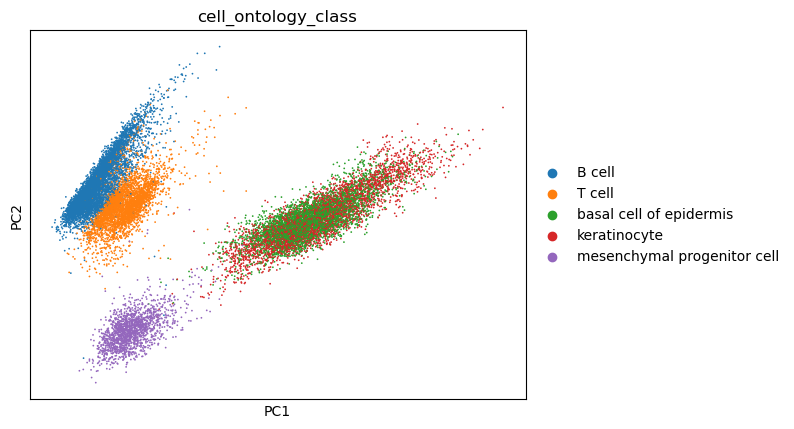

In [8]:
# run pca to select highly variable genes
sc.pp.pca(adata_sub, n_comps=50)
# plot pca
sc.pl.pca(adata_sub, color='cell_ontology_class', show=True)


In [9]:
# save pca layers
adata_sub.obsm['X_pca'] = adata_sub.obsm['X_pca'].copy()

/home/vannguyen/anaconda3/envs/gencell/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-15 14:50:28.544202: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 14:50:28.650565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


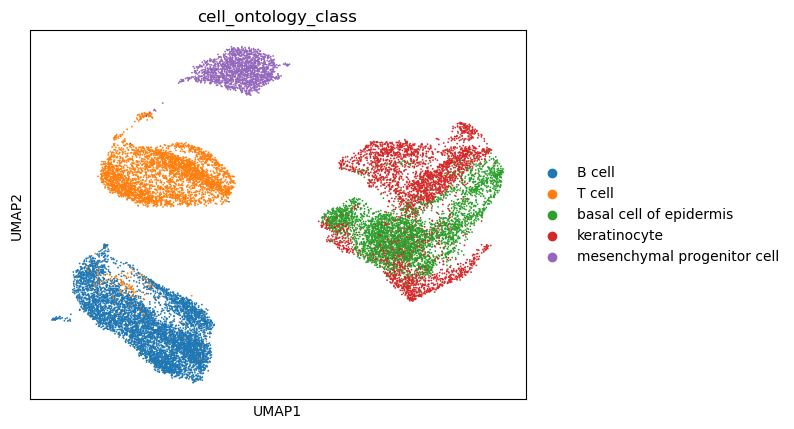

In [10]:
# running umap
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)
# plot umap
sc.pl.umap(adata_sub, color='cell_ontology_class', show=True)


Interpretation: The data seems cluster together, with B cell, T cell and mesenchymal are in separate cluster. Meanwhile basal and keratino are in the same cluster.

# Implementing Generative model for this data set

Diffusion: Destroy input --> Noise output --> Recover from this noise
Drawbacks: slow

Pipeline
Foward process: destroy the image by adding noise
Parametrized backward process: denoising the image (Markov chain-sequence of stochastic events-each time step depends on the precious time step)
Propeties of DF: 
+ Latent space dim = input dim
+ task: same as predict the noise that was added in each image (parametrized)
+ generate: start from random noise to construct new data

What we need:

+ Foward process = Noise scheduler: sequentially add noise
+ Backward process = Model (neural network): predict noise in image
+ Time step encoding
+ Loss

+ Ploting data: grey for original + other colors for generate

# Difussion model for generate data: Normal distribution for noise

* Training algorithm: 
1. For each training batch:
2. Forward process: sample true noise --> concat noise gene expression + label embedding + time embedding --> data
3. Reversed (denoise): data --> Decoder --> Predicted noise
4. Compute loss (true noise,predicted noise)

* Generating algorithm:
1. For each cell type:
2. Init random noise vector
3. Reserved process
4. Until t=0 (true data) --> return x_0
5. Collect data for each label

In [11]:
# foward process

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Linear schedule between start and end
    """
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos((x / timesteps + s) / (1 + s) * torch.pi * 0.5).clamp(0, 1) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Ensure starts at 1
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.02)  # Enforce upper limit

# retrieve values (beta,alpha) for each sample in a batch
def get_index_from_list(vals, t, x_shape): # TODO: check again this is not correct
    """
    Returns a specific index from a list of values vals
    while considering the batch dimension
    Args:
        vals: list of values (tensor of length T)
        t: tensor of indices (tensor of timestep index)
        x_shape: shape of the input tensor
    """
    batch_size = t.shape[0]
    out = vals.gather(-1,t.cpu()) # for each sample in the batch, get the value at index t

    # take a tensor 
    return out.reshape(batch_size, *([1] * (len(x_shape) - 1))).to(t.device)

def foward_diffusion_sample(x_0,t,device="cpu",prior="normal"): 
    """
    Performs the forward diffusion process:
    x_t = sqrt(alphas_cumprod[t]) * x_0 + sqrt(1 - alphas_cumprod[t]) * noise

    Parameters:
    - x_0: original data tensor
    - t: tensor of timesteps (int) for each sample
    - device: 'cpu' or 'cuda'

    Returns:
    - x_t: noisy version of x_0 at time t
    - noise: the noise that was added (useful for training)
    """

    if prior == "lognormal":
        mu = 0.0
        sigma = 1.0
        normal_noise = torch.randn_like(x_0)*sigma + mu
        noise = torch.exp(normal_noise)
    elif prior == "normal":
        noise = torch.randn_like(x_0)
    else:
        raise ValueError(f"Unknown prior: {prior}")
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape).to(device)
    sqrt_one_minus_alpha_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape).to(device)
    
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
    return x_t, noise
# define beta schedule
T = 1000
betas = cosine_beta_schedule(timesteps=T)

# pre-calculate different terms for closed form
alphas = 1. - betas

# compute cummulative product of alphas
alphas_cumprod = torch.cumprod(alphas,axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0) # pad the first element with 1


sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod + 1e-5)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

Explain get_index_from_list
Ex:
x_shape = (64,50) # input data shape
batch_size = 64

vals = torch.tensor([0.1,...,0.999]) # size =1000
t = torch.randint(0,1000,(64,))# random timestep for each sample in the batch: 
                                  create a 1D tensors t of shape (64,), containing 64 random int sample in the range 0 to 999 --> use to silmualate different noise level across the training data

out = vals.gather(-1,t) # shape (64,) --> random tensor(vals[3], vals[999], vals[0],...)
                                        this is the noie for each data sample

out.reshape(batch_size, *([1] * (len(x_shape) - 1))).to(t.device) # shape(batch_szie,1,1..) 
--> ensure we can apply noise to all sample and features (since we want to assign different scalar to each sample, then broadcast them across features )
                             

In [12]:
# apply forward diffusion

gene_exp_matrix = torch.tensor(adata_sub.X.toarray(),dtype=torch.float32)
data_mean = gene_exp_matrix.mean()
data_std = gene_exp_matrix.std()

gene_exp_matrix = (gene_exp_matrix - gene_exp_matrix.mean()) / gene_exp_matrix.std()


t = torch.randint(0, T, (gene_exp_matrix.shape[0],),dtype=torch.long)

# run foward diffusion
x_t,noise = foward_diffusion_sample(gene_exp_matrix,t,device="cpu",prior="normal")



UMAP visualization for noisy data

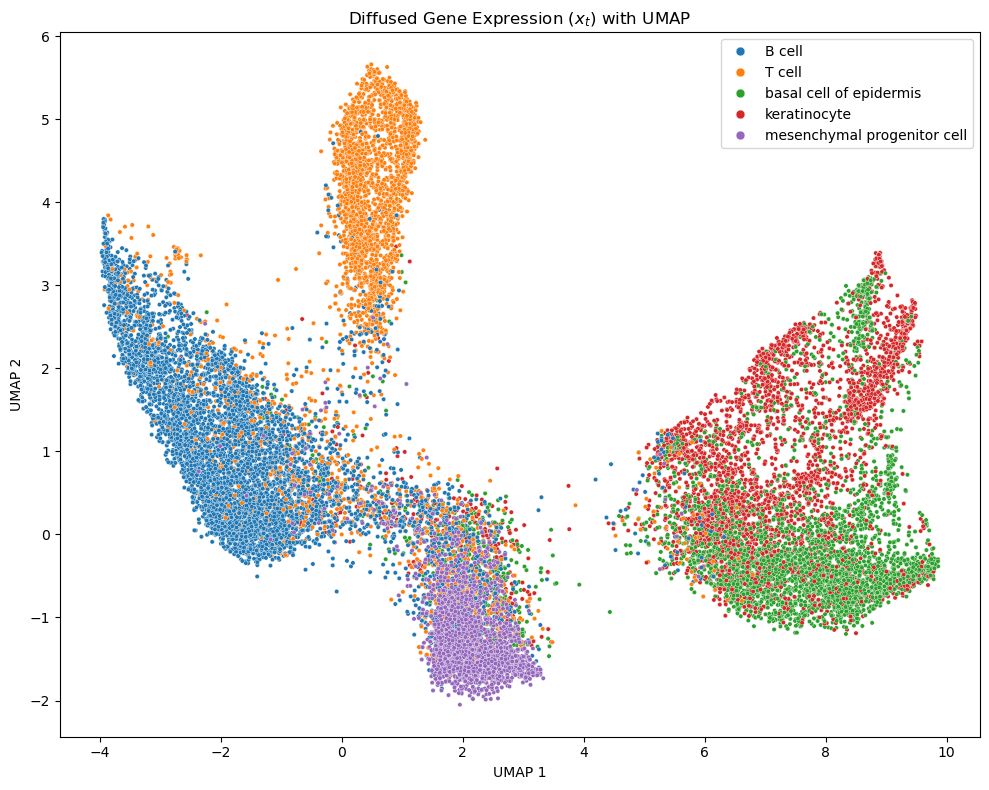

In [205]:
# visualize the noisy data

import umap

if len(x_t.shape) > 2:
    x_t_flat = x_t.view(x_t.shape[0], -1)
else:
    x_t_flat = x_t
# run UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(x_t.detach().cpu().numpy())

# create a dataframe for the UMAP plot
df = pd.DataFrame({
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1],
    "cell_type": adata_sub.obs['cell_ontology_class'].values
})
# plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2",hue="cell_type", s=10, palette="tab10")
plt.title("Diffused Gene Expression ($x_t$) with UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best", markerscale=2)
plt.tight_layout()
plt.show()

PCA visualization for noisy data

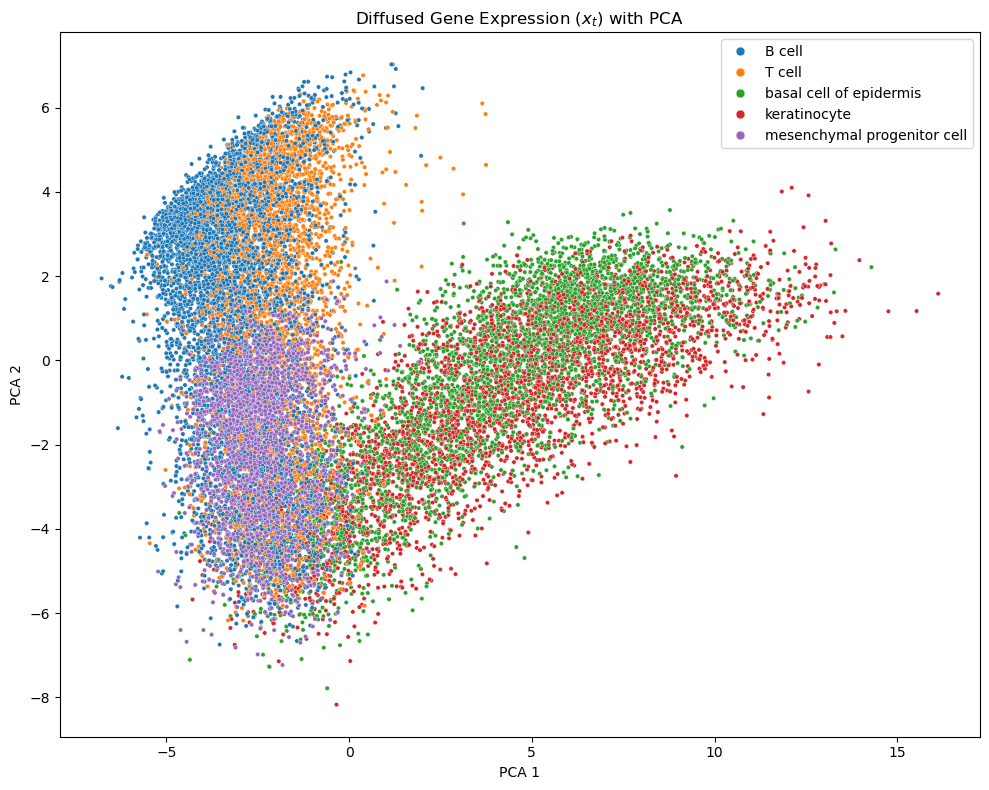

In [206]:
X_pca = PCA(n_components=2).fit_transform(x_t.cpu().numpy())
# create a dataframe for the PCA plot
df = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "cell_type": adata_sub.obs['cell_ontology_class'].values
})
# plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="PCA1", y="PCA2",hue="cell_type", s=10, palette="tab10")
plt.title("Diffused Gene Expression ($x_t$) with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="best", markerscale=2)
plt.tight_layout()
plt.show()


In [ ]:
# plot the noise added by time step
import joypy


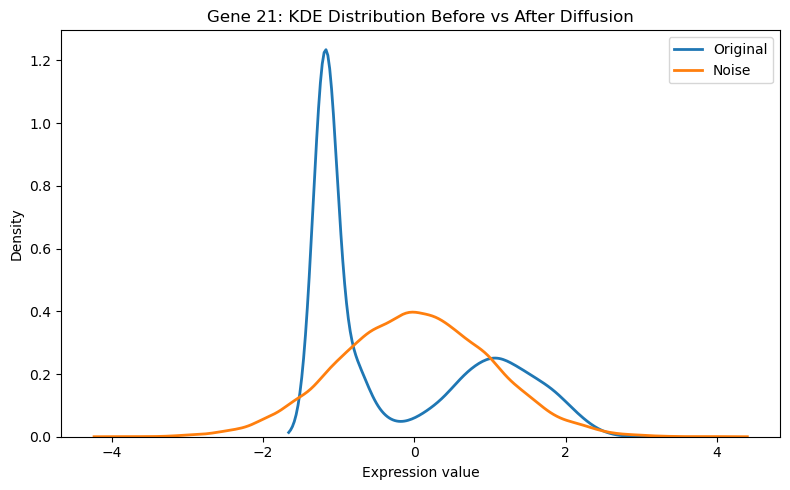

In [207]:
i = torch.randint(0, gene_exp_matrix.shape[1], (1,)).item()  # random gene index

plt.figure(figsize=(8, 5))
sns.kdeplot(gene_exp_matrix[:, i].cpu().numpy(), label='Original', linewidth=2)
sns.kdeplot(noise[:, i].cpu().numpy(), label='Noise', linewidth=2)
plt.legend()
plt.title(f'Gene {i}: KDE Distribution Before vs After Diffusion')
plt.xlabel('Expression value')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# TODO: The noise should be the same with normal distribution - bell curve

In [236]:
# Time embedding
class TimeEmbedding(nn.Module):
    """ 
    Time embedding module that maps time steps to a higher dim, dense vector 
    """
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
    
    def forward(self,t):
        half_dim = self.embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0))/(half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device = t.device) * -emb)
        emb =t.float()[:,None]*emb[None,:]
        emb = torch.cat([torch.sin(emb),torch.cos(emb)], dim=1)
        return emb

# Encode the labels
class LabelEncoder(nn.Module):
    """
    Label encoder that maps labels to a higher dim, use for conditional generation data
    """
    def __init__(self, num_classes, embedding_dim):
        super(LabelEncoder, self).__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, labels):
        return self.embedding(labels)

# Decoder
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,dropout_rate=0.3):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.LayerNorm(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.LayerNorm(hidden_dim)
    

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.LayerNorm(hidden_dim)
    

        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.bn4 = nn.LayerNorm(hidden_dim)
    


        self.fc5 = nn.Linear(hidden_dim, output_dim)

        


        # TODO: activation function: nonlinear - ReLU after 1 and 2 --> gelu instead
 

    def forward(self, x):
    
        x = F.relu(self.bn1(self.fc1(x)))
    
        x = F.relu(self.bn2(self.fc2(x)))
     
        x = F.relu(self.bn3(self.fc3(x)))


    
        x = F.relu(self.bn4(self.fc4(x))) 

        
        x = self.fc5(x)
      
        return x
    
# Diffusion Model
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_classes, embedding_dim,time_dim):
        super(DiffusionModel, self).__init__()
        self.encoder = LabelEncoder(num_classes, embedding_dim)
        self.time_embedding = TimeEmbedding(embedding_dim)
        self.decoder = Decoder(input_dim + 2*time_dim, hidden_dim, output_dim)
    def forward(self, x, labels,t):
        label_emb = F.relu(self.encoder(labels))
        time_emb = F.relu(self.time_embedding(t))
        # Concatenate the input data with the label and time embeddings: all information in 1 vector
        x = torch.cat([x, label_emb,time_emb], dim=1)
        return self.decoder(x)


# Hyperparameters
input_dim = gene_exp_matrix.shape[1]
hidden_dim = 1024 # can be higher
output_dim = gene_exp_matrix.shape[1]
num_classes = len(adata_sub.obs['cell_ontology_class'].unique())
embedding_dim = 256 # should be lower
num_epochs = 100
batch_size = 64
learning_rate = 1e-4


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model, loss function and optimizer
model = DiffusionModel(input_dim, hidden_dim, output_dim, num_classes, embedding_dim,time_dim=embedding_dim).to(device)
criterion=nn.MSELoss()

# weight decay (L2 regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=True
)


# Create a dataset

label_encoder = LabelEncoder(num_classes=num_classes,embedding_dim=embedding_dim)
label_mapping = {label: idx for idx, label in enumerate(adata_sub.obs['cell_ontology_class'].unique())}
encoded_labels = [label_mapping[label] for label in adata_sub.obs['cell_ontology_class']]
labels = torch.tensor(encoded_labels, dtype=torch.long)

# TODO: concat also the time step + labels into hidden layer/ have more hidden layer
# TODO: batch normalization for layer - avoid gd vanishing



In [237]:
dataset = TensorDataset(gene_exp_matrix, labels)
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [238]:
# Training loop
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# early stopping
best_val_loss = float('inf')
patience = 10
trigger_times = 0
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x_0, labels_batch in train_dataloader:

        # get a mini-batch of data
        x_0 = x_0.to(device)
        labels_batch = labels_batch.to(device)

        # sample random timesteps
        t = torch.randint(0, T, (x_0.shape[0],), dtype=torch.long).to(device)
        # foward diffusion
        x_t, noise = foward_diffusion_sample(x_0, t, device=device)

        predict_noise = model(x_t, labels_batch,t)
        # compute loss
        loss = criterion(predict_noise, noise)
        # Backward pass and optimization
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_0.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, labels_val in val_dataloader: 
            x_val = x_val.to(device)
            labels_val = labels_val.to(device)
            t_val = torch.randint(0, T, (x_val.shape[0],), dtype=torch.long).to(device)
            x_t_val, noise_val = foward_diffusion_sample(x_val, t_val, device=device)
            predict_noise_val = model(x_t_val, labels_val,t_val)
            val_loss += criterion(predict_noise_val, noise_val).item() * x_val.size(0)
    avg_val_loss = val_loss / len(val_dataloader.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Check for early stopping
    # if avg_val_loss < best_val_loss:
    #     best_val_loss = avg_val_loss
    #     trigger_times = 0
    # else:
    #     trigger_times += 1
    #     if trigger_times >= patience:
    #         print("Early stopping at epoch", epoch)
    #         break
    # Step the scheduler
    # scheduler.step(avg_val_loss)


Epoch [1/100], Loss: 0.5810
Validation Loss: 0.4847
Epoch [2/100], Loss: 0.2995
Validation Loss: 0.3185
Epoch [3/100], Loss: 0.2285
Validation Loss: 0.2812
Epoch [4/100], Loss: 0.2138
Validation Loss: 0.2592
Epoch [5/100], Loss: 0.1976
Validation Loss: 0.2439
Epoch [6/100], Loss: 0.1908
Validation Loss: 0.2348
Epoch [7/100], Loss: 0.1835
Validation Loss: 0.2288
Epoch [8/100], Loss: 0.1812
Validation Loss: 0.2310
Epoch [9/100], Loss: 0.1760
Validation Loss: 0.2223
Epoch [10/100], Loss: 0.1736
Validation Loss: 0.2163
Epoch [11/100], Loss: 0.1708
Validation Loss: 0.2160
Epoch [12/100], Loss: 0.1684
Validation Loss: 0.2099
Epoch [13/100], Loss: 0.1669
Validation Loss: 0.2180
Epoch [14/100], Loss: 0.1645
Validation Loss: 0.2083
Epoch [15/100], Loss: 0.1624
Validation Loss: 0.2071
Epoch [16/100], Loss: 0.1611
Validation Loss: 0.2044
Epoch [17/100], Loss: 0.1599
Validation Loss: 0.1972
Epoch [18/100], Loss: 0.1636
Validation Loss: 0.2016
Epoch [19/100], Loss: 0.1594
Validation Loss: 0.1951
Ep

In [239]:
# Save the model

filepath = './weight/diffusion_model_normal.pth'
torch.save(model.state_dict(), filepath)
# Load the model
model.load_state_dict(torch.load(filepath))



/tmp/ipykernel_1001837/2685834253.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


<All keys matched successfully>

In [240]:
def reverse_diffusion(model, label, num_steps, shape, device):
    model.eval()
    with torch.no_grad():
        # Start from pure Gaussian noise
        x = torch.randn(shape).to(device)
        label_tensor = torch.tensor([label] * shape[0], dtype=torch.long).to(device)

        for t_step in reversed(range(num_steps)):
            t = torch.tensor([t_step] * shape[0], dtype=torch.long).to(device)
            predicted_noise = model(x, label_tensor, t)
            beta_t  = get_index_from_list(betas, t, x.shape).to(device)
            sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape).to(device)
            sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape).to(device) 
            posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape).to(device)
            # Compute the mean and variance for the reverse process
            model_mean = sqrt_recip_alphas_t * (x - beta_t * predicted_noise/ sqrt_one_minus_alphas_cumprod_t)
            if t_step > 0:
                noise = torch.randn_like(x)
                x = model_mean + torch.sqrt(posterior_variance_t) * noise
            else:
                noise = model_mean
        

    return x.cpu()


In [241]:
print(label_mapping) 

{'keratinocyte': 0, 'basal cell of epidermis': 1, 'T cell': 2, 'B cell': 3, 'mesenchymal progenitor cell': 4}


In [242]:
# Generate new samples
num_samples = 1000
all_generated = []
all_labels = []

for label_name, label_id in label_mapping.items():
    generated_samples = reverse_diffusion(model, label=label_id, num_steps=T, shape=(num_samples, input_dim), device=device)
    all_generated.append(generated_samples.cpu())
    all_labels.extend([label_name] * num_samples)

# reverse the normalization
all_generated = torch.cat(all_generated, dim=0)
all_generated = all_generated * data_std + data_mean



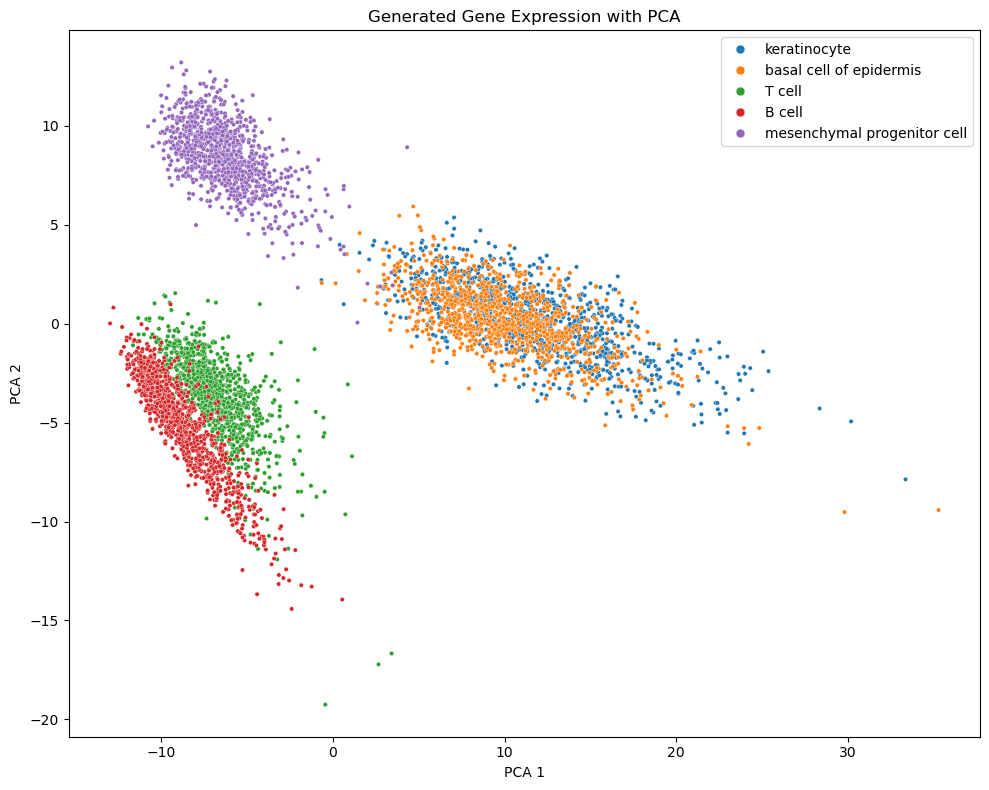

In [243]:
# visualize the generated data using PCA
X_pca = PCA(n_components=2).fit_transform(all_generated.numpy())
# create a dataframe for the PCA plot
df = pd.DataFrame({
    "PCA1": X_pca[:, 0],
    "PCA2": X_pca[:, 1],
    "cell_type": all_labels
})
# plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="PCA1", y="PCA2",hue="cell_type", s=10, palette="tab10")
plt.title("Generated Gene Expression with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="best", markerscale=2)
plt.tight_layout()
plt.show()

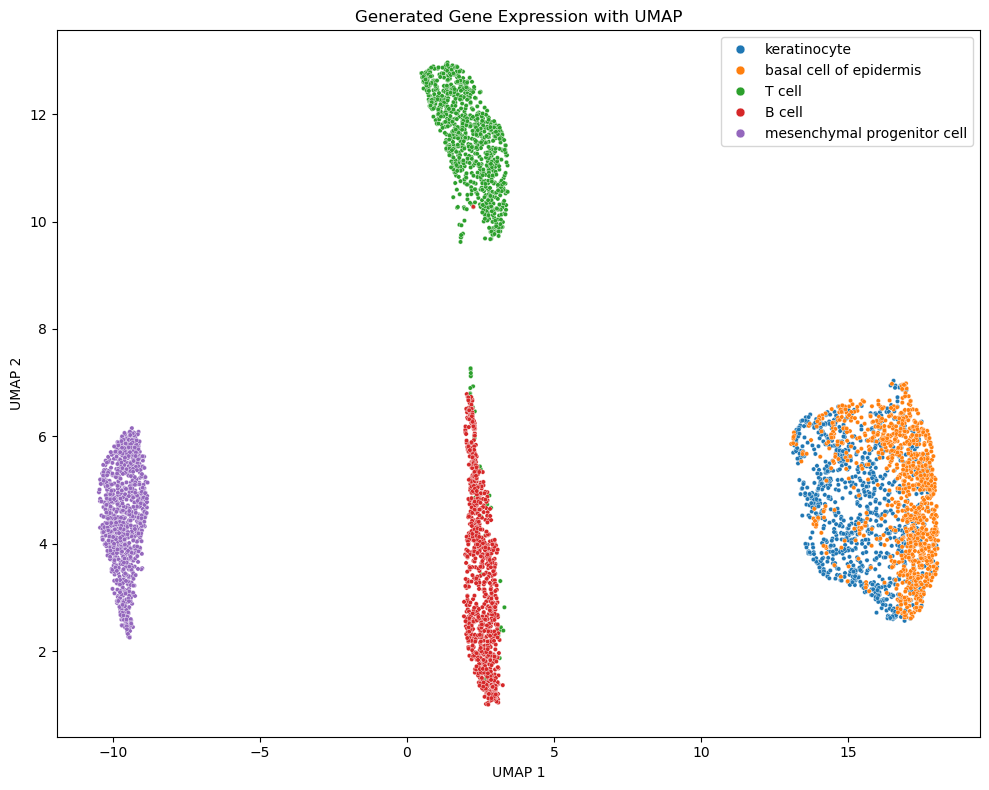

In [244]:
# visualize the generated samples
# run UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_generated.numpy())
# create a dataframe for the UMAP plot
df = pd.DataFrame({
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1],
    "cell_type": all_labels
})
# plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2",hue="cell_type", s=10, palette="tab10")
plt.title("Generated Gene Expression with UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best", markerscale=2)
plt.tight_layout()
plt.show()



In [245]:
# After generation, invert normalization
all_generated = all_generated * data_std + data_mean

# Verify generated data matches original scale
print("Generated Data - Mean: {:.2f}, Std: {:.2f}".format(
    all_generated.mean().item(), all_generated.std().item()
))
print("Original Data - Mean: {:.2f}, Std: {:.2f}".format(
    data_mean.item(), data_std.item()
))

Generated Data - Mean: 5.84, Std: 3.14
Original Data - Mean: 2.08, Std: 1.77


# Evaluate: Using energy distance

In [247]:
from scipy.spatial.distance import cdist

def multivariate_energy_distance(X,Y):
    """
    Computes the multivariate energy distance between two samples X and Y.
    - X: real data (n_samples,d_features)
    - Y: generated data (m_samples,d_features)
    """
    n, d = X.shape
    m, d = Y.shape

    # compute pairwise distances
    d_xy = cdist(X, Y,metric="euclidean")
    d_xx = cdist(X, X,metric="euclidean")
    d_yy = cdist(Y, Y,metric="euclidean")

    # compute expectation terms
    e_xy = np.mean(d_xy)
    e_xx = np.mean(d_xx)
    e_yy = np.mean(d_yy)

    return np.sqrt(2*e_xy - e_xx - e_yy)



generated_data =  all_generated.numpy()

generated_dict = {}
start = 0
for label_name in label_mapping:
    generated_dict[label_name] = generated_data[start:start + num_samples]
    start += num_samples

energy_distances = {}
for label_name, label_id in label_mapping.items():

    original_data = gene_exp_matrix[labels==label_id].cpu().numpy()
    generated_data = generated_dict[label_name]
    energy_dist = multivariate_energy_distance(original_data, generated_data)
    energy_distances[label_name] = energy_dist
    print(f"Energy distance for {label_name}: {energy_dist:.4f}")


Energy distance for keratinocyte: 11.3454
Energy distance for basal cell of epidermis: 11.4469
Energy distance for T cell: 10.5960
Energy distance for B cell: 10.5783
Energy distance for mesenchymal progenitor cell: 10.3485


# Difussion model for generating data: Lognormal distribution

In [ ]:
# sampling z_T from a log_normal distribution


# modify the model
class DiffusionModelLogNormal(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_classes, embedding_dim,time_dim):
        super(DiffusionModelLogNormal, self).__init__()
        self.encoder = LabelEncoder(num_classes, embedding_dim)
        self.time_embedding = TimeEmbedding(embedding_dim)
        self.decoder = Decoder(input_dim + embedding_dim + time_dim, hidden_dim, output_dim)

    def forward(self, x, labels,t):
        label_embeddings = self.encoder(labels)
        time_embeddings = self.time_embedding(t)
        x = torch.cat((x, label_embeddings,time_embeddings), dim=1)
        return self.decoder(x)

class LogNormalNLLLoss(nn.Module):
    def __init__(self, mu=0.0,sigma=1.0):
        super().__init__()
        self.mu = mu
        self.sigma = sigma

    
    def forward(self,predicted, target):
        """
        Compute the negative log-likelihood loss for log-normal distribution
        """
        target = torch.clamp(target, min=1e-5)
        predicted = torch.nn.functional.softplus(predicted) + 1e-5
        
        mu = predicted
        lognormal = LogNormal(loc=mu,scale=self.sigma)

        nll = -lognormal.log_prob(target)
        return torch.mean(nll)

    
# Initialize the model, loss function and optimizer
model_lognormal = DiffusionModelLogNormal(input_dim, hidden_dim, output_dim, num_classes, embedding_dim,time_dim=embedding_dim).to(device)
criterion = LogNormalNLLLoss(mu=0.0,sigma=1.0)
# weight decay (L2 regularization)
optimizer = torch.optim.Adam(model_lognormal.parameters(), lr=learning_rate,weight_decay=1e-5)
# Create a dataset
dataset = TensorDataset(gene_exp_matrix, labels)
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Training loop
for epoch in range(num_epochs):
    model_lognormal.train()
    epoch_loss = 0.0
    for x_0, labels_batch in dataloader:

        # get a mini-batch of data
        x_0 = x_0.to(device)
        labels_batch = labels_batch.to(device)

        # sample random timesteps
        t = torch.randint(0, T, (x_0.shape[0],), dtype=torch.long).to(device)
        # foward diffusion
        
        x_t, noise = foward_diffusion_sample(x_0, t, device=device, prior="lognormal")

 
        predict_noise = model_lognormal(x_t, labels_batch,t)
        # compute loss
        loss = criterion(predict_noise, noise)
        # Backward pass and optimization
        torch.nn.utils.clip_grad_norm_(model_lognormal.parameters(), max_norm=1.0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_0.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the model
filepath = './weight/diffusion_model_lognormal.pth'
torch.save(model_lognormal.state_dict(), filepath)




Epoch [1/50], Loss: 1.5704
Epoch [2/50], Loss: 1.3327
Epoch [3/50], Loss: 1.2872
Epoch [4/50], Loss: 1.2505
Epoch [5/50], Loss: 1.2119
Epoch [6/50], Loss: 1.1754
Epoch [7/50], Loss: 1.1464
Epoch [8/50], Loss: 1.1246
Epoch [9/50], Loss: 1.1117
Epoch [10/50], Loss: 1.1046
Epoch [11/50], Loss: 1.0919
Epoch [12/50], Loss: 1.0863
Epoch [13/50], Loss: 1.0842
Epoch [14/50], Loss: 1.0829
Epoch [15/50], Loss: 1.0774
Epoch [16/50], Loss: 1.0805
Epoch [17/50], Loss: 1.0765
Epoch [18/50], Loss: 1.0769
Epoch [19/50], Loss: 1.0740
Epoch [20/50], Loss: 1.0742
Epoch [21/50], Loss: 1.0728
Epoch [22/50], Loss: 1.0738
Epoch [23/50], Loss: 1.0719
Epoch [24/50], Loss: 1.0726
Epoch [25/50], Loss: 1.0744
Epoch [26/50], Loss: 1.0734
Epoch [27/50], Loss: 1.0704
Epoch [28/50], Loss: 1.0756
Epoch [29/50], Loss: 1.0710
Epoch [30/50], Loss: 1.0722
Epoch [31/50], Loss: 1.0729
Epoch [32/50], Loss: 1.0713
Epoch [33/50], Loss: 1.0748
Epoch [34/50], Loss: 1.0770
Epoch [35/50], Loss: 1.0712
Epoch [36/50], Loss: 1.0691
E

/tmp/ipykernel_628076/2597427517.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lognormal.load_state_dict(torch.load(filepath))


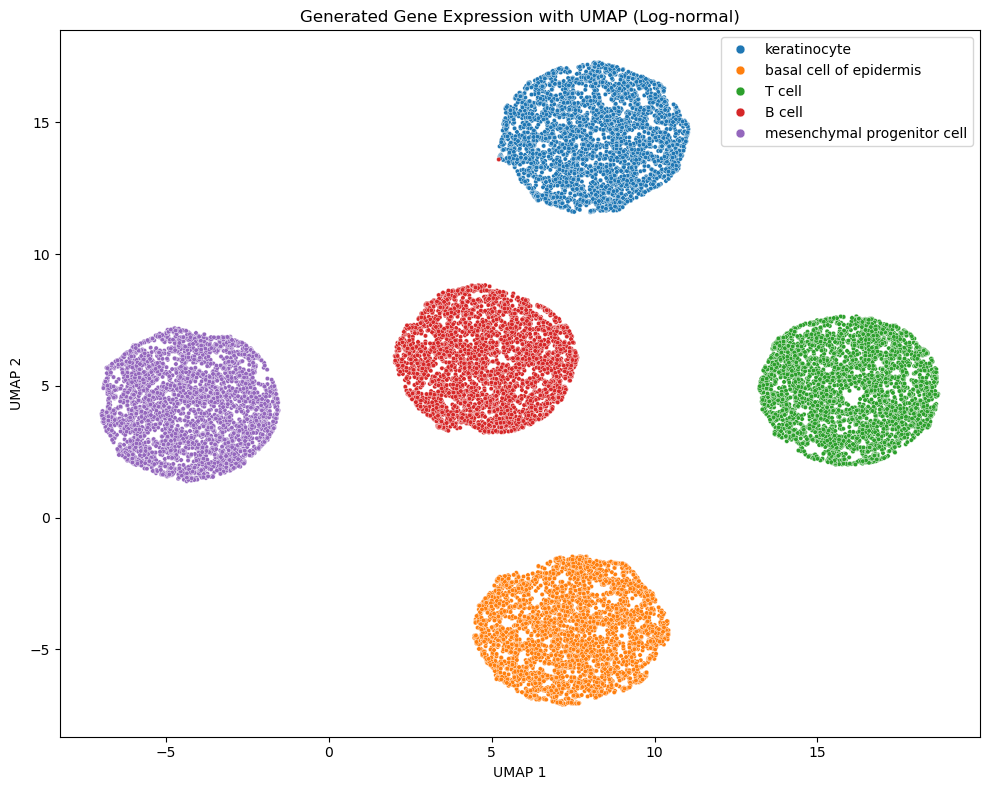

In [201]:
# Load the model
model_lognormal.load_state_dict(torch.load(filepath))
# Generate new samples
num_samples = 4000
all_generated_lognormal = []
all_labels_lognormal = []
for label_name, label_id in label_mapping.items():
    generated_samples = reverse_diffusion(model_lognormal, label=label_id, num_steps=T, shape=(num_samples, input_dim), device=device)
    all_generated_lognormal.append(generated_samples.cpu())
    all_labels_lognormal.extend([label_name] * num_samples)
all_generated_tensor_lognormal = torch.cat(all_generated_lognormal, dim=0)
# visualize the generated samples
# run UMAP  
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_generated_tensor_lognormal.numpy())
# create a dataframe for the UMAP plot
df = pd.DataFrame({
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1],
    "cell_type": all_labels_lognormal
})
# plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2",hue="cell_type", s=10, palette="tab10")
plt.title("Generated Gene Expression with UMAP (Log-normal)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best", markerscale=2)
plt.tight_layout()
plt.show()


In [202]:
# compute energy distance
generated_data =  all_generated_tensor_lognormal.numpy()
generated_dict_lognormal = {}
start = 0
for label_name in label_mapping:
    generated_dict_lognormal[label_name] = generated_data[start:start + num_samples]
    start += num_samples

energy_distances_lognormal = {}
for label_name, label_id in label_mapping.items():

    original_data = gene_exp_matrix[labels==label_id].cpu().numpy()
    generated_data = generated_dict_lognormal[label_name]
    energy_dist = multivariate_energy_distance(original_data, generated_data)
    energy_distances_lognormal[label_name] = energy_dist
    print(f"Energy distance for {label_name}: {energy_dist:.4f}")
    

Energy distance for keratinocyte: 7.7606
Energy distance for basal cell of epidermis: 7.8518
Energy distance for T cell: 6.4705
Energy distance for B cell: 6.3091
Energy distance for mesenchymal progenitor cell: 5.7391


# VAE model for generating data

* Training Algorithm:
1. Encode input + label to get mu and logvar
2. Sample latent z using reparametrization
3. Decode z + label to get recon_x
4. Compute loss + update weights using Adam optimizer

* Generating algorithm:
1. For each cell type:
2. Sample latent vector + label
3. Pass through decoder
4. Append data with its label

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, label_emb_dim):
        """
        Conditional Variational Autoencoder (CVAE) for gene expression data.
        Args:
            input_dim (int): Dimension of the input data (gene expression).
            hidden_dim (int): Dimension of the hidden layers.
            latent_dim (int): Dimension of the latent space.
            num_classes (int): Number of cell types.
            label_emb_dim (int): Dimension of the label embeddings: turn labels into vectors
        """
        
        super(ConditionalVAE,self).__init__()

        # Embedding layer for labels
        self.label_embedding = nn.Embedding(num_classes, label_emb_dim)

        # Encoder: maps (x+label) --> latent distribution (mu,logvar)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + label_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        # Output of encoder: mean and log variance of latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: maps (z+label) --> reconstructed gene expression vector
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + label_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def encode(self, x, labels):
        # Embedding labels and concatenate with input
        label_emb = self.label_embedding(labels)
        x = torch.cat([x,label_emb],dim=1) # shape: batch_size x (input_dim + label_emb_dim)
        h = self.encoder(x) # shape: batch_size x hidden_dim
        # Compute mean and log variance
        return self.fc_mu(h), self.fc_logvar(h) 
    
    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z ~ N(mu,sigma^2)
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std) # random noise
        return mu + eps * std
    
    def decode(self,z,labels):
        # Decode latent vector z + label into reconstructed data
        label_emb = self.label_embedding(labels)
        z = torch.cat([z,label_emb],dim=1)
        return self.decoder(z)
    
    def forward(self,x,labels):
        # Forward pass: encode, reparameterize and decode
        mu, logvar = self.encode(x,labels)
        z = self.reparameterize(mu,logvar)
        recon_x = self.decode(z,labels)
        return recon_x, mu, logvar

# loss function
def vae_loss(recon_x,x,mu,logvar):
    recon_loss = F.mse_loss(recon_x,x,reduction='mean')
    kl_div = -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp())
    return recon_loss + kl_div

latent_dim = 32
hidden_dim = 128
label_emb_dim = 64
num_epochs = 50
batch_size = 32
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function and optimizer
model = ConditionalVAE(input_dim, hidden_dim, latent_dim, num_classes, label_emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Create a dataset
dataset = TensorDataset(gene_exp_matrix, labels)
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [119]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x_0, labels_batch in dataloader:
        # get a mini-batch of data
        x_0 = x_0.to(device)
        labels_batch = labels_batch.to(device)

        # Forward pass
        recon_x, mu, logvar = model(x_0, labels_batch)
        # Compute loss
        loss = vae_loss(recon_x, x_0, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * x_0.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/50], Loss: 0.5483
Epoch [2/50], Loss: 0.3206
Epoch [3/50], Loss: 0.2949
Epoch [4/50], Loss: 0.2825
Epoch [5/50], Loss: 0.2767
Epoch [6/50], Loss: 0.2724
Epoch [7/50], Loss: 0.2707
Epoch [8/50], Loss: 0.2692
Epoch [9/50], Loss: 0.2677
Epoch [10/50], Loss: 0.2665
Epoch [11/50], Loss: 0.2653
Epoch [12/50], Loss: 0.2644
Epoch [13/50], Loss: 0.2642
Epoch [14/50], Loss: 0.2636
Epoch [15/50], Loss: 0.2623
Epoch [16/50], Loss: 0.2631
Epoch [17/50], Loss: 0.2618
Epoch [18/50], Loss: 0.2618
Epoch [19/50], Loss: 0.2611
Epoch [20/50], Loss: 0.2605
Epoch [21/50], Loss: 0.2609
Epoch [22/50], Loss: 0.2597
Epoch [23/50], Loss: 0.2599
Epoch [24/50], Loss: 0.2594
Epoch [25/50], Loss: 0.2595
Epoch [26/50], Loss: 0.2589
Epoch [27/50], Loss: 0.2585
Epoch [28/50], Loss: 0.2584
Epoch [29/50], Loss: 0.2583
Epoch [30/50], Loss: 0.2580
Epoch [31/50], Loss: 0.2580
Epoch [32/50], Loss: 0.2579
Epoch [33/50], Loss: 0.2579
Epoch [34/50], Loss: 0.2580
Epoch [35/50], Loss: 0.2576
Epoch [36/50], Loss: 0.2570
E

In [157]:
# plot the latent embedding of the dataset

def plot_latent_space(model,data_loader, device, label_mapping):
    model.eval()
    all_mu = []
    all_labels = []
    
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            mu, _ = model.encode(x_batch, y_batch)
            all_mu.append(mu.cpu())
            all_labels.append(y_batch.cpu())
    
    # stack all mu and labels
    all_mu = torch.cat(all_mu, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # reduce dimension for visualization
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1,metric='euclidean')
    embedding = reducer.fit_transform(all_mu)

    inv_label_mapping = {v: k for k, v in label_mapping.items()}
    label_names = [inv_label_mapping[int(label)] for label in all_labels]

    df = pd.DataFrame({
        "UMAP1": embedding[:, 0],
        "UMAP2": embedding[:, 1],
        "cell_type": label_names
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="cell_type", s=10, palette="tab10")
    plt.title("Latent Space with UMAP")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    


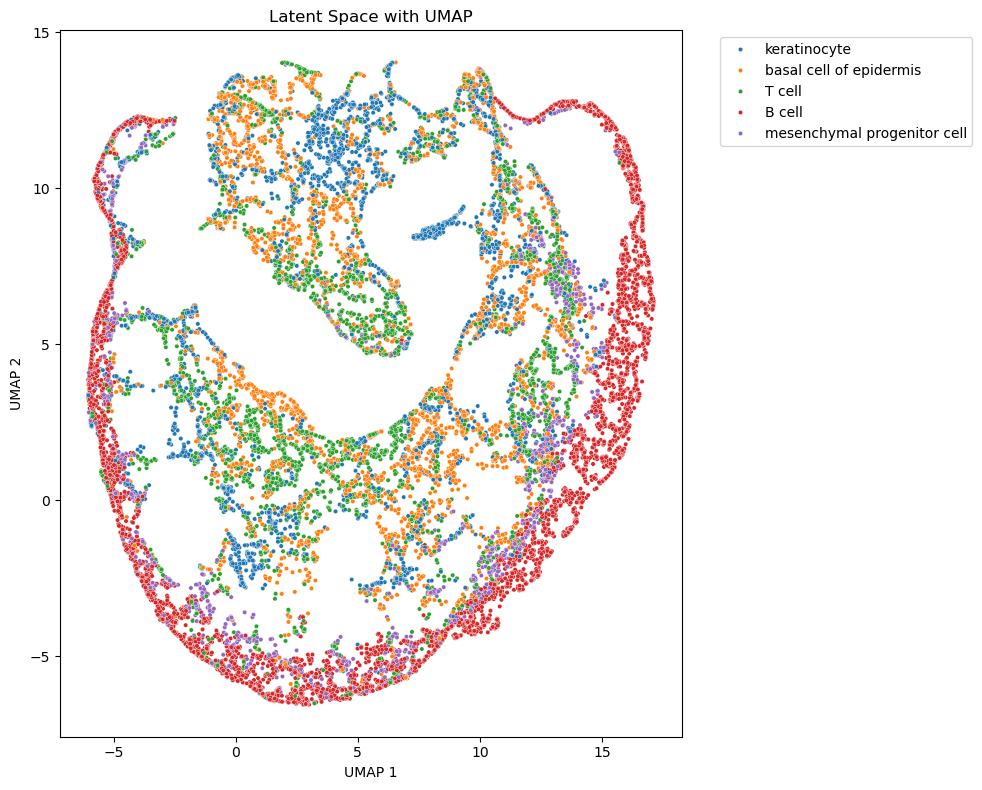

In [158]:
# plot the latent space 
plot_latent_space(model, dataloader, device, label_mapping)

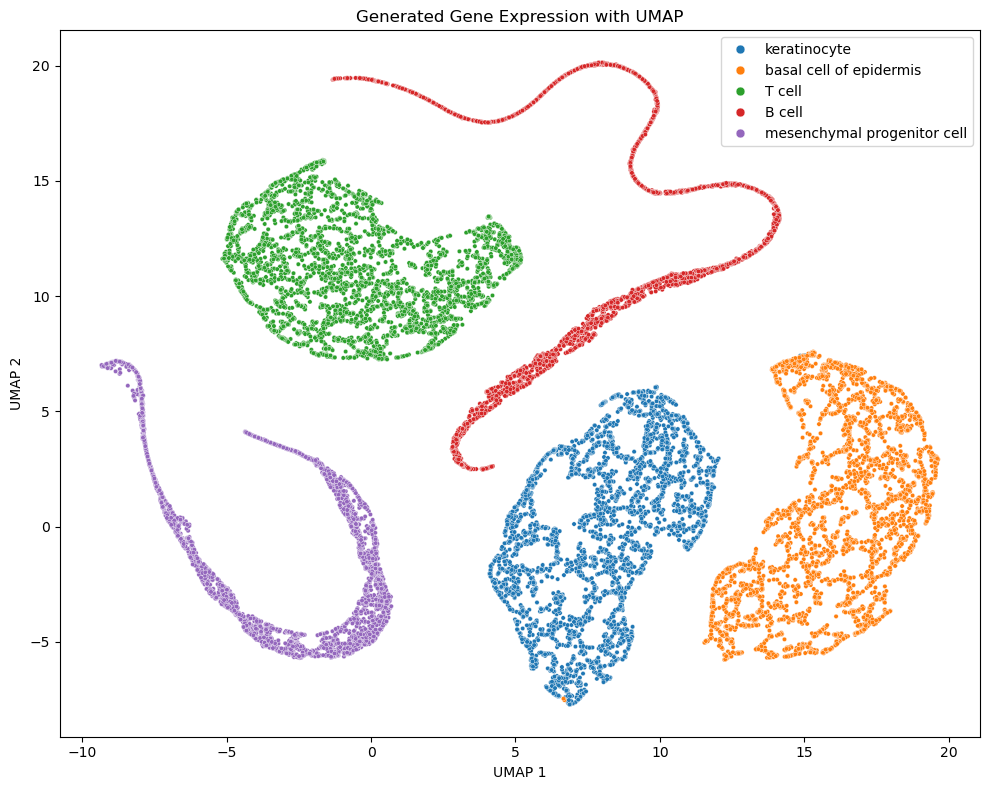

In [121]:
def generate_samples_vae(model,label_id,numsamples,device):
    model.eval()
    with torch.no_grad():
        # Sample random latent vectors
        z = torch.randn(numsamples, latent_dim).to(device)
        # Create label tensor
        labels = torch.tensor([label_id] * numsamples, dtype=torch.long).to(device)
        # Decode to generate samples
        generated_samples = model.decode(z,labels)
    return generated_samples.cpu()
# Generate new samples
num_samples = 4000
all_generated_vae = []
all_labels_vae = []

for label_name, label_id in label_mapping.items():
    generated_samples = generate_samples_vae(model, label_id, numsamples=num_samples, device=device)
    all_generated_vae.append(generated_samples.cpu())
    all_labels_vae.extend([label_name] * num_samples)
all_generated_vae_tensor = torch.cat(all_generated_vae, dim=0)
# visualize the generated samples
# run UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_generated_vae_tensor.numpy())
# create a dataframe for the UMAP plot
df = pd.DataFrame({
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1],
    "cell_type": all_labels_vae
})
# plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2",hue="cell_type", s=10, palette="tab10")
plt.title("Generated Gene Expression with UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best", markerscale=2)
plt.tight_layout()
plt.show()


In [122]:
# evaluating data generate from VAE
generated_data_vae =  all_generated_vae_tensor.numpy()
generated_dict_vae = {}
start = 0
for label_name in label_mapping:
    generated_dict_vae[label_name] = generated_data_vae[start:start + num_samples]
    start += num_samples
energy_distances_vae = {}
for label_name, label_id in label_mapping.items():
    original_data = gene_exp_matrix[labels==label_id].cpu().numpy()
    generated_data = generated_dict_vae[label_name]
    energy_dist = multivariate_energy_distance(original_data, generated_data)
    energy_distances_vae[label_name] = energy_dist
    print(f"Energy distance for {label_name}: {energy_dist:.4f}")
    

Energy distance for keratinocyte: 0.7670
Energy distance for basal cell of epidermis: 0.9272
Energy distance for T cell: 0.9158
Energy distance for B cell: 0.9626
Energy distance for mesenchymal progenitor cell: 1.3255


# Gaussian Mixture Model for generating data

* Training algorithm: 
1. For each cell type
2. Take all samples belonging to that cell type
3. Fit 1-component GMM
4. Store the fitted GMM in gmm_dict

* Generating algorithm:
1. For each cell type
2. Sample points from trained GMM
3. Inverse scaling to original space
4. Return torch.tensor data
5. Append data to its cell type

In [126]:
X = gene_exp_matrix.cpu().numpy()
y = labels.cpu().numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm_dict = {}
# Fit GMM
for label_name, label_id in label_mapping.items():
    X_class = X_scaled[y == label_id]
    gmm = GaussianMixture(n_components=1, covariance_type='full',random_state=42)
    gmm.fit(X_class)
    gmm_dict[label_name] = gmm

# Generate new samples
def generate_samples_gmm(dmm_dict,label_name,num_samples,scaler):
    gmm = gmm_dict[label_name]
    samples, _ = gmm.sample(num_samples)
    samples = scaler.inverse_transform(samples)
    return torch.tensor(samples, dtype=torch.float32)

# Generate new samples
num_samples = 4000
all_generated_gmm = []
all_labels_gmm = []
for label_name in label_mapping:
    generated_samples = generate_samples_gmm(gmm_dict,label_name,num_samples,scaler)
    all_generated_gmm.append(generated_samples.cpu())
    all_labels_gmm.extend([label_name] * num_samples)
all_generated_gmm_tensor = torch.cat(all_generated_gmm, dim=0)


In [217]:
gmm_dict

{'keratinocyte': GaussianMixture(random_state=42),
 'basal cell of epidermis': GaussianMixture(random_state=42),
 'T cell': GaussianMixture(random_state=42),
 'B cell': GaussianMixture(random_state=42),
 'mesenchymal progenitor cell': GaussianMixture(random_state=42)}

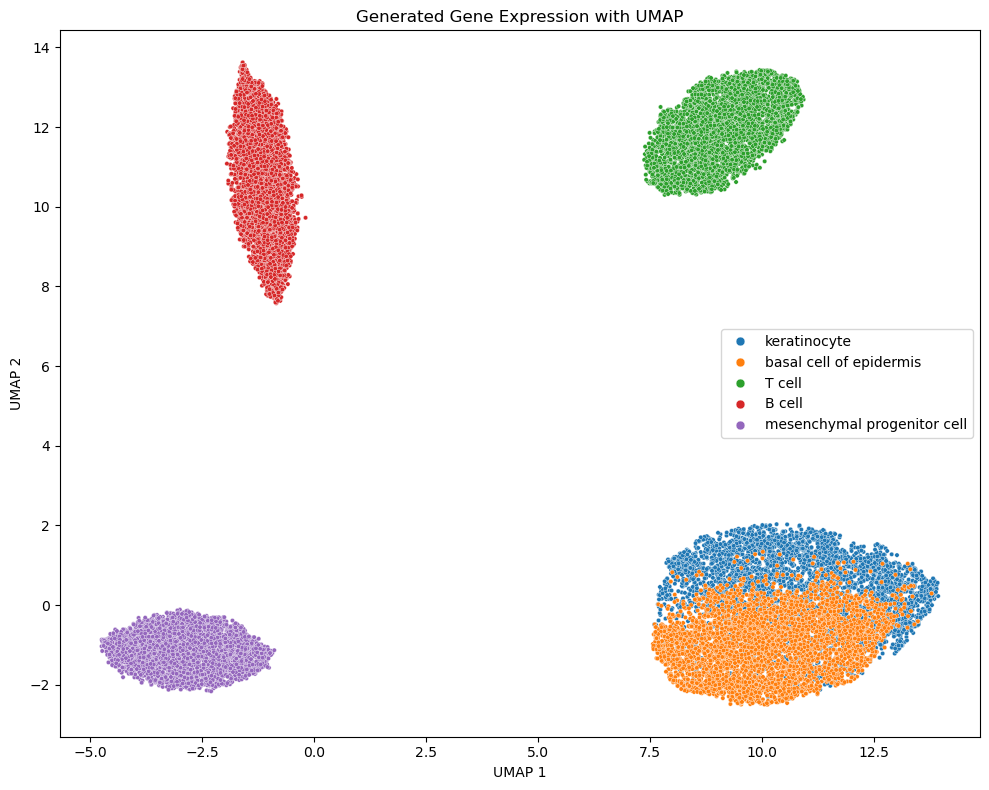

In [127]:
# visualize the generated samples
# run UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(all_generated_gmm_tensor.numpy())
# create a dataframe for the UMAP plot
df = pd.DataFrame({
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1],
    "cell_type": all_labels_gmm
})
# plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2",hue="cell_type", s=10, palette="tab10")
plt.title("Generated Gene Expression with UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(loc="best", markerscale=2)
plt.tight_layout()
plt.show()


In [128]:
# evaluate the generated data
generated_data_gmm =  all_generated_gmm_tensor.numpy()
generated_dict_gmm = {}
start = 0
for label_name in label_mapping:
    generated_dict_gmm[label_name] = generated_data_gmm[start:start + num_samples]
    start += num_samples
    
energy_distances_gmm = {}
for label_name, label_id in label_mapping.items():
    original_data = gene_exp_matrix[labels==label_id].cpu().numpy()
    generated_data = generated_dict_gmm[label_name]
    energy_dist = multivariate_energy_distance(original_data, generated_data)
    energy_distances_gmm[label_name] = energy_dist
    print(f"Energy distance for {label_name}: {energy_dist:.4f}")

Energy distance for keratinocyte: 0.1696
Energy distance for basal cell of epidermis: 0.2324
Energy distance for T cell: 0.1892
Energy distance for B cell: 0.1389
Energy distance for mesenchymal progenitor cell: 0.0936
